In [1]:
! ls /home/ian.harry/tmp_abi

template_bank  test  train  training_labels.csv


In [2]:
!ls /home/ian.harry/tmp_abi/template_bank

templates_097.h5  templates_099.h5


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pylab as py
import pandas as pd 
import pycbc
import glob, os
import h5py
import lal 
import seaborn as sns

%matplotlib inline
#pycbc specifically for gravitational wave astronomy. For more information on github, follow this link: https://github.com/gwastro/pycbc
import pycbc.noise
import pycbc.filter
import pycbc.psd
from pycbc.filter import highpass_fir, matched_filter, matched_filter_core, MatchedFilterControl, sigmasq
from pycbc.filter.matchedfilter import Correlator
from pycbc.types import zeros
from pycbc.fft import IFFT
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.waveform import td_approximants, fd_approximants

from scipy.signal import tukey
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, plot_confusion_matrix


## Dictionaries 

In [4]:
#Csv file of data ids and their coresponding targets. 
training_labels = pd.read_csv("/home/ian.harry/tmp_abi/training_labels.csv")

In [5]:
#Dictionary containing ids and targets
tl = np.loadtxt('/home/ian.harry/tmp_abi/training_labels.csv',dtype='str', delimiter=',',skiprows=1)

dict_tl={}

for i in tl:
    dict_tl[i[0]] = i[1]  

## PSD

In [6]:
#Compute the PSD, code inspired from  my supervisor Ian Harry. 
data_in = glob.glob('/home/ian.harry/tmp_abi/train/0/0/0/*.npy')

det1_psd = None 
det2_psd = None 
det3_psd = None 
count = 0

for filename in data_in:
    file_id = filename.split("/")[8].split('.')[0] #Splits the file path to just the id name
    
    if dict_tl[file_id] == 1: #skips all signals
        continue
    count += 1
    
    example_arr = np.load(filename)
    det1 = pycbc.types.TimeSeries(example_arr[0], delta_t= 1./2048.) 
    det2 = pycbc.types.TimeSeries(example_arr[1], delta_t= 1./2048.) 
    det3 = pycbc.types.TimeSeries(example_arr[2], delta_t= 1./2048.)
    window = np.hanning(4096) 
    
    det1 = det1*window #applies window to minimise wrap arouind effect. 
    det2 = det2*window
    det3 = det3*window 
    
    det1f = det1.to_frequencyseries() #Transform into the frequency domain
    det2f = det2.to_frequencyseries()
    det3f = det3.to_frequencyseries()
    
    if count == 1:
        det1_psd = abs(det1f)
        det2_psd = abs(det2f)
        det3_psd = abs(det3f)
    else:
        det1_psd = (abs(det1f) + (count-1) * det1_psd)/count
        det2_psd = (abs(det2f) + (count-1) * det2_psd)/count 
        det3_psd = (abs(det3f) + (count-1) * det3_psd)/count
        
det1_psd = det1_psd**2 * 4096/ (window*window).sum() # computes the average PSD
det2_psd = det2_psd**2 * 4096/ (window*window).sum()
det3_psd = det3_psd**2 * 4096/ (window*window).sum()
    

(1e-48, 1e-44)

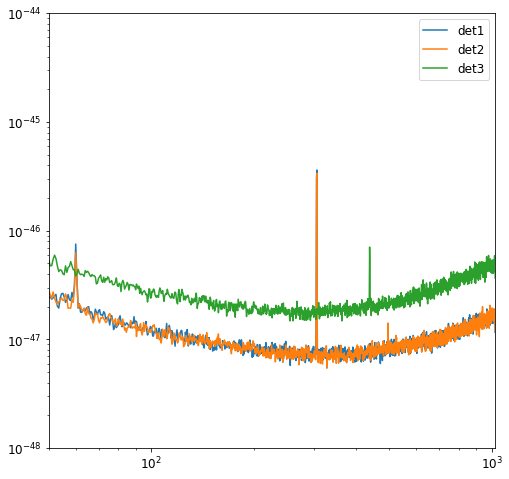

In [7]:
%matplotlib inline
py.figure(figsize=(8,8))
py.loglog(det1_psd.sample_frequencies, det1_psd, label='det1')
py.loglog(det2_psd.sample_frequencies, det2_psd, label='det2')
py.loglog(det3_psd.sample_frequencies, det3_psd,label='det3')
py.legend()
py.xlim(50,1024)
py.ylim(10e-49,10e-45)

## Generating Waveforms

In [8]:
#Template bank provided by Ian Harry - contains 3000 waveforms
templates = h5py.File('/home/ian.harry/tmp_abi/template_bank/templates_097.h5', mode= 'r')
mass1s = (templates['mass1'][:])
mass2s = (templates['mass2'][:])
spin1z = (templates['spin1z'][:])
spin2z = (templates['spin2z'][:])

In [9]:
#contains 10,000 waveforms
templatesv2 = h5py.File('/home/ian.harry/tmp_abi/template_bank/templates_099.h5', mode= 'r')
mass1s2 = (templatesv2['mass1'][:])
mass2s2 = (templatesv2['mass2'][:])
spin1z2 = (templatesv2['spin1z'][:])
spin2z2 = (templatesv2['spin2z'][:])

In [10]:
#function to compute the lower frequency for the set of masses
def f_lower(M_chirp):
    return (5**(3/8))/(8*np.pi*((M_chirp**(5/3)*1)**(3/8)))

In [ ]:
#py.figure(figsize=(10,10))
for m1, m2, s1z, s2z in zip(mass1s,mass2s,spin1z,spin2z):
    mu = ((m1*m2)/(m1+m2))
    M = m1+m2
    M_chirp = (mu**(3/5))*(M**(2/5))*lal.MTSUN_SI # computing the chirp mass
    hp,hc = get_fd_waveform(approximant='IMRPhenomD',
                                                      mass1 = m1,
                                                      mass2 = m2, 
                                                      spin1z = s1z,
                                                      spin2z = s2z,
                                                      delta_f=det1_psd.delta_f, # frequency step
                                                      f_lower=f_lower(M_chirp),
                                                      f_upper=1024)
    py.plot(hp.sample_frequencies,hp)
print(hp.delta_f,len(hp)) 

In [12]:
print(det1f.delta_f,hp.delta_f,det1_psd.delta_f)
hp.resize(len(det1f))

0.5 0.5 0.5


## Match Filtering

In [13]:
#Assigning ids to a path
training_labels = pd.read_csv("/home/ian.harry/tmp_abi/training_labels.csv")

path = list(training_labels['id'])
for i in range(len(path)):
    path[i] = '/home/ian.harry/tmp_abi/train/' + path[i][0] +  '/' + path[i][1] +  '/' + path[i][2] +  '/' + path[i] + '.npy'
print(path[1])

/home/ian.harry/tmp_abi/train/0/0/0/00001f4945.npy


In [14]:
data_size = len(path)//5 # reducing the data size
print(data_size)
data_size1 = (data_size)//5
print(data_size1)
data_1 = path[0:data_size1]
data_2 = path[22400:44800]
data_3 = path[44800:67200]
data_4 = path[67200:89600]
data_5 = path[89600:112000]

112000
22400


In [ ]:
#Same principle as my code but optimized by Ian Harry

det_filter_final1 = []
from pycbc.filter.matchedfilter import _BaseCorrelator

class CPUCorrelator(_BaseCorrelator):
    def __init__(self, x, y, z):
        self.x = np.array(x.data, copy=False)
        self.y = np.array(y.data, copy=False)
        self.z = np.array(z.data, copy=False)

    def correlate(self):
        self.z[:] = np.conjugate(self.x.data)
        self.z *= self.y

print("Pregenerating waveforms and normalizations")
pregenerated_waveforms = []
pregenerated_sigma1s = []
pregenerated_sigma2s = []
pregenerated_sigma3s = []

for m1, m2, s1z, s2z in zip(mass1s,mass2s,spin1z,spin2z):
        mu = ((m1*m2)/(m1+m2))
        M = m1+m2
        M_chirp = (mu**(3/5))*(M**(2/5))*lal.MTSUN_SI
        hp,hc = get_fd_waveform(approximant='IMRPhenomD',
                                                          mass1 = m1,
                                                          mass2 = m2, 
                                                          spin1z = s1z,
                                                          spin2z = s2z,
                                                          delta_f= det1_psd.delta_f,
                                                          f_lower=f_lower(M_chirp),
                                                          f_upper=1000)
        hp.resize(len(det1_psd))
        pregenerated_waveforms.append(hp)
        # sigma squared is a normalisation constant to compute the correct SNR.
        template_norm1 = sigmasq(hp, det1_psd, low_frequency_cutoff=30, high_frequency_cutoff=1000) #normalising the templates 
        template_norm2 = sigmasq(hp, det2_psd, low_frequency_cutoff=30, high_frequency_cutoff=1000)
        template_norm3 = sigmasq(hp, det3_psd, low_frequency_cutoff=30, high_frequency_cutoff=1000)
        pregenerated_sigma1s.append(template_norm1)
        pregenerated_sigma2s.append(template_norm2)
        pregenerated_sigma3s.append(template_norm3)

print("Beginning to process data")

    
det_filter_final1 = []
for filname in data_1:
    
    ##### GET DATA
    ex_arr = np.load(filname)
    print(filname, filname.split('/')[-1][:-4], dict_tl[filname.split('/')[-1][:-4]])

    ex_arr = np.load(filname)
    window = tukey(4096, alpha=0.05)

    det1_ts = pycbc.types.TimeSeries(ex_arr[0], delta_t= 1./2048.) 
    det1_ts = det1_ts * window 
    det2_ts = pycbc.types.TimeSeries(ex_arr[1], delta_t= 1./2048.) 
    det2_ts = det2_ts * window 
    det3_ts = pycbc.types.TimeSeries(ex_arr[2], delta_t= 1./2048.)
    det3_ts = det3_ts * window 


    det1_fs = det1_ts.to_frequencyseries()
    det2_fs = det2_ts.to_frequencyseries()
    det3_fs = det3_ts.to_frequencyseries()
    
    # Apply PSD here
    det1_fs = det1_fs / det1_psd
    det2_fs = det2_fs / det2_psd
    det3_fs = det3_fs / det3_psd
    
    ##### SET UP CORRELATORS AND FFTs

    tlen = 2 * 2048 # Length of data is 4096 data points
    flen = tlen // 2 + 1
    data_time_length = 2
    template_mem1 = zeros(tlen, dtype = np.complex128)
    template_mem2 = zeros(tlen, dtype = np.complex128)
    template_mem3 = zeros(tlen, dtype = np.complex128)
    snr_mem1 = zeros(tlen, dtype=np.complex128)
    snr_mem2 = zeros(tlen, dtype=np.complex128)
    snr_mem3 = zeros(tlen, dtype=np.complex128)
    corr_mem1 = zeros(tlen, dtype=np.complex128)
    corr_mem2 = zeros(tlen, dtype=np.complex128)
    corr_mem3 = zeros(tlen, dtype=np.complex128)
    # Low and high frequency cutoffs
    kmin = 30 * data_time_length
    kmax = 1000 * data_time_length
    corr_slice = slice(kmin, kmax)
    corr1 = CPUCorrelator(template_mem1[corr_slice], det1_fs[corr_slice], corr_mem1[corr_slice])
    corr2 = CPUCorrelator(template_mem2[corr_slice], det2_fs[corr_slice], corr_mem2[corr_slice])
    corr3 = CPUCorrelator(template_mem3[corr_slice], det3_fs[corr_slice], corr_mem3[corr_slice])
    ifft1 = IFFT(corr_mem1, snr_mem1)
    ifft2 = IFFT(corr_mem2, snr_mem2)
    ifft3 = IFFT(corr_mem3, snr_mem3)
        
    max_icv = 0
    count = 0
    for (hp, ps1, ps2, ps3) in zip(pregenerated_waveforms, pregenerated_sigma1s, pregenerated_sigma2s, pregenerated_sigma3s):

        count += 1
        if count % 1000 == 0:
            print (count, 'of', len(mass1s)) # basic tqdm
        template_mem1._data[:len(hp)] = hp._data[:]
        template_mem2._data[:len(hp)] = hp._data[:]
        template_mem3._data[:len(hp)] = hp._data[:]
        
        template_norm1 = ps1
        template_norm2 = ps2
        template_norm3 = ps3

        norm1 = (4.0 * det1_psd.delta_f) / np.sqrt(template_norm1) # normalisation constant 
        norm2 = (4.0 * det2_psd.delta_f) / np.sqrt(template_norm2)
        norm3 = (4.0 * det3_psd.delta_f) / np.sqrt(template_norm3)
        
        corr1.correlate()
        ifft1.execute()
        
        corr2.correlate()
        ifft2.execute()

        corr3.correlate()
        ifft3.execute()
                 
        # NOTE [2048:3686] is -1, -0.2 ... But I swapped to 3030:3745
        max_det1_filter = abs(snr_mem1._data[3030:3745]).argmax()
        det1_max = abs(snr_mem1._data[max_det1_filter+3030]) * norm1 # finding the max snr
    
        max_det2_filter = abs(snr_mem2._data[3030:3745]).argmax()
        det2_max = abs(snr_mem2._data[max_det2_filter+3030]) * norm2
  
        max_det3_filter = abs(snr_mem3._data[3030:3745]).argmax()
        det3_max = abs(snr_mem3._data[max_det3_filter+3030]) * norm3
        
        max_filter = (det1_max+det2_max+det3_max)
        
        
        if max_filter > max_icv:
            max_icv = max_filter
            
                
    
    det_filter_final1.append((max_icv, filname.split('/')[-1][:-4]))
  



In [ ]:
det_filter_final2 = []
from pycbc.filter.matchedfilter import _BaseCorrelator

class CPUCorrelator(_BaseCorrelator):
    def __init__(self, x, y, z):
        self.x = np.array(x.data, copy=False)
        self.y = np.array(y.data, copy=False)
        self.z = np.array(z.data, copy=False)

    def correlate(self):
        self.z[:] = np.conjugate(self.x.data)
        self.z *= self.y

print("Pregenerating waveforms and normalizations")
pregenerated_waveforms = []
pregenerated_sigma1s = []
pregenerated_sigma2s = []
pregenerated_sigma3s = []

for m1, m2, s1z, s2z in zip(mass1s,mass2s,spin1z,spin2z):
        mu = ((m1*m2)/(m1+m2))
        M = m1+m2
        M_chirp = (mu**(3/5))*(M**(2/5))*lal.MTSUN_SI
        hp,hc = get_fd_waveform(approximant='IMRPhenomD',
                                                          mass1 = m1,
                                                          mass2 = m2, 
                                                          spin1z = s1z,
                                                          spin2z = s2z,
                                                          delta_f= det1_psd.delta_f,
                                                          f_lower=f_lower(M_chirp),
                                                          f_upper=1000)
        hp.resize(len(det1_psd))
        pregenerated_waveforms.append(hp)
        template_norm1 = sigmasq(hp, det1_psd, low_frequency_cutoff=30, high_frequency_cutoff=1000)
        template_norm2 = sigmasq(hp, det2_psd, low_frequency_cutoff=30, high_frequency_cutoff=1000)
        template_norm3 = sigmasq(hp, det3_psd, low_frequency_cutoff=30, high_frequency_cutoff=1000)
        pregenerated_sigma1s.append(template_norm1)
        pregenerated_sigma2s.append(template_norm2)
        pregenerated_sigma3s.append(template_norm3)

print("Beginning to process data")

    
det_filter_final2 = []
for filname in data_2:
    
    ##### GET DATA
    ex_arr = np.load(filname)
    print(filname, filname.split('/')[-1][:-4], dict_tl[filname.split('/')[-1][:-4]])

    ex_arr = np.load(filname)
    window = tukey(4096, alpha=0.05)

    det1_ts = pycbc.types.TimeSeries(ex_arr[0], delta_t= 1./2048.)
    det1_ts = det1_ts * window 
    det2_ts = pycbc.types.TimeSeries(ex_arr[1], delta_t= 1./2048.) 
    det2_ts = det2_ts * window 
    det3_ts = pycbc.types.TimeSeries(ex_arr[2], delta_t= 1./2048.)
    det3_ts = det3_ts * window 


    det1_fs = det1_ts.to_frequencyseries()
    det2_fs = det2_ts.to_frequencyseries()
    det3_fs = det3_ts.to_frequencyseries()
    
    # Apply PSD here
    det1_fs = det1_fs / det1_psd
    det2_fs = det2_fs / det2_psd
    det3_fs = det3_fs / det3_psd
    
    ##### SET UP CORRELATORS AND FFTs

    tlen = 2 * 2048 # Length of data is 4096 data points
    flen = tlen // 2 + 1
    data_time_length = 2
    template_mem1 = zeros(tlen, dtype = np.complex128)
    template_mem2 = zeros(tlen, dtype = np.complex128)
    template_mem3 = zeros(tlen, dtype = np.complex128)
    snr_mem1 = zeros(tlen, dtype=np.complex128)
    snr_mem2 = zeros(tlen, dtype=np.complex128)
    snr_mem3 = zeros(tlen, dtype=np.complex128)
    corr_mem1 = zeros(tlen, dtype=np.complex128)
    corr_mem2 = zeros(tlen, dtype=np.complex128)
    corr_mem3 = zeros(tlen, dtype=np.complex128)
    # Low and high frequency cutoffs
    kmin = 30 * data_time_length
    kmax = 1000 * data_time_length
    corr_slice = slice(kmin, kmax)
    corr1 = CPUCorrelator(template_mem1[corr_slice], det1_fs[corr_slice], corr_mem1[corr_slice])
    corr2 = CPUCorrelator(template_mem2[corr_slice], det2_fs[corr_slice], corr_mem2[corr_slice])
    corr3 = CPUCorrelator(template_mem3[corr_slice], det3_fs[corr_slice], corr_mem3[corr_slice])
    ifft1 = IFFT(corr_mem1, snr_mem1)
    ifft2 = IFFT(corr_mem2, snr_mem2)
    ifft3 = IFFT(corr_mem3, snr_mem3)
        
    max_icv = 0
    count = 0
    for (hp, ps1, ps2, ps3) in zip(pregenerated_waveforms, pregenerated_sigma1s, pregenerated_sigma2s, pregenerated_sigma3s):

        count += 1
        if count % 1000 == 0:
            print (count, 'of', len(mass1s)) # basic tqdm
        template_mem1._data[:len(hp)] = hp._data[:]
        template_mem2._data[:len(hp)] = hp._data[:]
        template_mem3._data[:len(hp)] = hp._data[:]
        
        template_norm1 = ps1
        template_norm2 = ps2
        template_norm3 = ps3

        norm1 = (4.0 * det1_psd.delta_f) / np.sqrt(template_norm1)
        norm2 = (4.0 * det2_psd.delta_f) / np.sqrt(template_norm2)
        norm3 = (4.0 * det3_psd.delta_f) / np.sqrt(template_norm3)
        
        corr1.correlate()
        ifft1.execute()
        
        corr2.correlate()
        ifft2.execute()

        corr3.correlate()
        ifft3.execute()
                 
        # NOTE [2048:3686] is -1, -0.2 ... But I swapped to 3030:3745
        max_det1_filter = abs(snr_mem1._data[3030:3745]).argmax()
        det1_max = abs(snr_mem1._data[max_det1_filter+3030]) * norm1
    
        max_det2_filter = abs(snr_mem2._data[3030:3745]).argmax()
        det2_max = abs(snr_mem2._data[max_det2_filter+3030]) * norm2
  
        max_det3_filter = abs(snr_mem3._data[3030:3745]).argmax()
        det3_max = abs(snr_mem3._data[max_det3_filter+3030]) * norm3
        
        max_filter = (det1_max+det2_max+det3_max)
        
        
        if max_filter > max_icv:
            max_icv = max_filter
            
                
    
    det_filter_final2.append((max_icv, filname.split('/')[-1][:-4]))

In [ ]:
det_filter_final3 = []
from pycbc.filter.matchedfilter import _BaseCorrelator

class CPUCorrelator(_BaseCorrelator):
    def __init__(self, x, y, z):
        self.x = np.array(x.data, copy=False)
        self.y = np.array(y.data, copy=False)
        self.z = np.array(z.data, copy=False)

    def correlate(self):
        self.z[:] = np.conjugate(self.x.data)
        self.z *= self.y

print("Pregenerating waveforms and normalizations")
pregenerated_waveforms = []
pregenerated_sigma1s = []
pregenerated_sigma2s = []
pregenerated_sigma3s = []

for m1, m2, s1z, s2z in zip(mass1s,mass2s,spin1z,spin2z):
        mu = ((m1*m2)/(m1+m2))
        M = m1+m2
        M_chirp = (mu**(3/5))*(M**(2/5))*lal.MTSUN_SI
        hp,hc = get_fd_waveform(approximant='IMRPhenomD',
                                                          mass1 = m1,
                                                          mass2 = m2, 
                                                          spin1z = s1z,
                                                          spin2z = s2z,
                                                          delta_f= det1_psd.delta_f,
                                                          f_lower=f_lower(M_chirp),
                                                          f_upper=1000)
        hp.resize(len(det1_psd))
        pregenerated_waveforms.append(hp)
        template_norm1 = sigmasq(hp, det1_psd, low_frequency_cutoff=30, high_frequency_cutoff=1000)
        template_norm2 = sigmasq(hp, det2_psd, low_frequency_cutoff=30, high_frequency_cutoff=1000)
        template_norm3 = sigmasq(hp, det3_psd, low_frequency_cutoff=30, high_frequency_cutoff=1000)
        pregenerated_sigma1s.append(template_norm1)
        pregenerated_sigma2s.append(template_norm2)
        pregenerated_sigma3s.append(template_norm3)

print("Beginning to process data")

    
det_filter_final3 = []
for filname in data_3:
    
    ##### GET DATA
    ex_arr = np.load(filname)
    print(filname, filname.split('/')[-1][:-4], dict_tl[filname.split('/')[-1][:-4]])

    ex_arr = np.load(filname)
    window = tukey(4096, alpha=0.05)

    det1_ts = pycbc.types.TimeSeries(ex_arr[0], delta_t= 1./2048.)
    det1_ts = det1_ts * window 
    det2_ts = pycbc.types.TimeSeries(ex_arr[1], delta_t= 1./2048.) 
    det2_ts = det2_ts * window 
    det3_ts = pycbc.types.TimeSeries(ex_arr[2], delta_t= 1./2048.)
    det3_ts = det3_ts * window 


    det1_fs = det1_ts.to_frequencyseries()
    det2_fs = det2_ts.to_frequencyseries()
    det3_fs = det3_ts.to_frequencyseries()
    
    # Apply PSD here
    det1_fs = det1_fs / det1_psd
    det2_fs = det2_fs / det2_psd
    det3_fs = det3_fs / det3_psd
    
    ##### SET UP CORRELATORS AND FFTs

    tlen = 2 * 2048 # Length of data is 4096 data points
    flen = tlen // 2 + 1
    data_time_length = 2
    template_mem1 = zeros(tlen, dtype = np.complex128)
    template_mem2 = zeros(tlen, dtype = np.complex128)
    template_mem3 = zeros(tlen, dtype = np.complex128)
    snr_mem1 = zeros(tlen, dtype=np.complex128)
    snr_mem2 = zeros(tlen, dtype=np.complex128)
    snr_mem3 = zeros(tlen, dtype=np.complex128)
    corr_mem1 = zeros(tlen, dtype=np.complex128)
    corr_mem2 = zeros(tlen, dtype=np.complex128)
    corr_mem3 = zeros(tlen, dtype=np.complex128)
    # Low and high frequency cutoffs
    kmin = 30 * data_time_length
    kmax = 1000 * data_time_length
    corr_slice = slice(kmin, kmax)
    corr1 = CPUCorrelator(template_mem1[corr_slice], det1_fs[corr_slice], corr_mem1[corr_slice])
    corr2 = CPUCorrelator(template_mem2[corr_slice], det2_fs[corr_slice], corr_mem2[corr_slice])
    corr3 = CPUCorrelator(template_mem3[corr_slice], det3_fs[corr_slice], corr_mem3[corr_slice])
    ifft1 = IFFT(corr_mem1, snr_mem1)
    ifft2 = IFFT(corr_mem2, snr_mem2)
    ifft3 = IFFT(corr_mem3, snr_mem3)
        
    max_icv = 0
    count = 0
    for (hp, ps1, ps2, ps3) in zip(pregenerated_waveforms, pregenerated_sigma1s, pregenerated_sigma2s, pregenerated_sigma3s):

        count += 1
        if count % 1000 == 0:
            print (count, 'of', len(mass1s)) # basic tqdm
        template_mem1._data[:len(hp)] = hp._data[:]
        template_mem2._data[:len(hp)] = hp._data[:]
        template_mem3._data[:len(hp)] = hp._data[:]
        
        template_norm1 = ps1
        template_norm2 = ps2
        template_norm3 = ps3

        norm1 = (4.0 * det1_psd.delta_f) / np.sqrt(template_norm1)
        norm2 = (4.0 * det2_psd.delta_f) / np.sqrt(template_norm2)
        norm3 = (4.0 * det3_psd.delta_f) / np.sqrt(template_norm3)
        
        corr1.correlate()
        ifft1.execute()
        
        corr2.correlate()
        ifft2.execute()

        corr3.correlate()
        ifft3.execute()
                 
        # NOTE [2048:3686] is -1, -0.2 ... But I swapped to 3030:3745
        max_det1_filter = abs(snr_mem1._data[3030:3745]).argmax()
        det1_max = abs(snr_mem1._data[max_det1_filter+3030]) * norm1
    
        max_det2_filter = abs(snr_mem2._data[3030:3745]).argmax()
        det2_max = abs(snr_mem2._data[max_det2_filter+3030]) * norm2
  
        max_det3_filter = abs(snr_mem3._data[3030:3745]).argmax()
        det3_max = abs(snr_mem3._data[max_det3_filter+3030]) * norm3
        
        max_filter = (det1_max+det2_max+det3_max)
        
        
        if max_filter > max_icv:
            max_icv = max_filter
            
                
    
    det_filter_final3.append((max_icv, filname.split('/')[-1][:-4]))

In [ ]:
det_filter_final4 = []
from pycbc.filter.matchedfilter import _BaseCorrelator

class CPUCorrelator(_BaseCorrelator):
    def __init__(self, x, y, z):
        self.x = np.array(x.data, copy=False)
        self.y = np.array(y.data, copy=False)
        self.z = np.array(z.data, copy=False)

    def correlate(self):
        self.z[:] = np.conjugate(self.x.data)
        self.z *= self.y

print("Pregenerating waveforms and normalizations")
pregenerated_waveforms = []
pregenerated_sigma1s = []
pregenerated_sigma2s = []
pregenerated_sigma3s = []

for m1, m2, s1z, s2z in zip(mass1s,mass2s,spin1z,spin2z):
        mu = ((m1*m2)/(m1+m2))
        M = m1+m2
        M_chirp = (mu**(3/5))*(M**(2/5))*lal.MTSUN_SI
        hp,hc = get_fd_waveform(approximant='IMRPhenomD',
                                                          mass1 = m1,
                                                          mass2 = m2, 
                                                          spin1z = s1z,
                                                          spin2z = s2z,
                                                          delta_f= det1_psd.delta_f,
                                                          f_lower=f_lower(M_chirp),
                                                          f_upper=1000)
        hp.resize(len(det1_psd))
        pregenerated_waveforms.append(hp)
        template_norm1 = sigmasq(hp, det1_psd, low_frequency_cutoff=30, high_frequency_cutoff=1000)
        template_norm2 = sigmasq(hp, det2_psd, low_frequency_cutoff=30, high_frequency_cutoff=1000)
        template_norm3 = sigmasq(hp, det3_psd, low_frequency_cutoff=30, high_frequency_cutoff=1000)
        pregenerated_sigma1s.append(template_norm1)
        pregenerated_sigma2s.append(template_norm2)
        pregenerated_sigma3s.append(template_norm3)

print("Beginning to process data")

    
det_filter_final4 = []
for filname in data_4:
    
    ##### GET DATA
    ex_arr = np.load(filname)
    print(filname, filname.split('/')[-1][:-4], dict_tl[filname.split('/')[-1][:-4]])

    ex_arr = np.load(filname)
    window = tukey(4096, alpha=0.05)

    det1_ts = pycbc.types.TimeSeries(ex_arr[0], delta_t= 1./2048.)
    det1_ts = det1_ts * window 
    det2_ts = pycbc.types.TimeSeries(ex_arr[1], delta_t= 1./2048.) 
    det2_ts = det2_ts * window 
    det3_ts = pycbc.types.TimeSeries(ex_arr[2], delta_t= 1./2048.)
    det3_ts = det3_ts * window 

    det1_fs = det1_ts.to_frequencyseries()
    det2_fs = det2_ts.to_frequencyseries()
    det3_fs = det3_ts.to_frequencyseries()
    
    # Apply PSD here
    det1_fs = det1_fs / det1_psd
    det2_fs = det2_fs / det2_psd
    det3_fs = det3_fs / det3_psd
    
    ##### SET UP CORRELATORS AND FFTs

    tlen = 2 * 2048 # Length of data is 4096 data points
    flen = tlen // 2 + 1
    data_time_length = 2
    template_mem1 = zeros(tlen, dtype = np.complex128)
    template_mem2 = zeros(tlen, dtype = np.complex128)
    template_mem3 = zeros(tlen, dtype = np.complex128)
    snr_mem1 = zeros(tlen, dtype=np.complex128)
    snr_mem2 = zeros(tlen, dtype=np.complex128)
    snr_mem3 = zeros(tlen, dtype=np.complex128)
    corr_mem1 = zeros(tlen, dtype=np.complex128)
    corr_mem2 = zeros(tlen, dtype=np.complex128)
    corr_mem3 = zeros(tlen, dtype=np.complex128)
    # Low and high frequency cutoffs
    kmin = 30 * data_time_length
    kmax = 1000 * data_time_length
    corr_slice = slice(kmin, kmax)
    corr1 = CPUCorrelator(template_mem1[corr_slice], det1_fs[corr_slice], corr_mem1[corr_slice])
    corr2 = CPUCorrelator(template_mem2[corr_slice], det2_fs[corr_slice], corr_mem2[corr_slice])
    corr3 = CPUCorrelator(template_mem3[corr_slice], det3_fs[corr_slice], corr_mem3[corr_slice])
    ifft1 = IFFT(corr_mem1, snr_mem1)
    ifft2 = IFFT(corr_mem2, snr_mem2)
    ifft3 = IFFT(corr_mem3, snr_mem3)
        
    max_icv = 0
    count = 0
    for (hp, ps1, ps2, ps3) in zip(pregenerated_waveforms, pregenerated_sigma1s, pregenerated_sigma2s, pregenerated_sigma3s):

        count += 1
        if count % 1000 == 0:
            print (count, 'of', len(mass1s)) # basic tqdm
        template_mem1._data[:len(hp)] = hp._data[:]
        template_mem2._data[:len(hp)] = hp._data[:]
        template_mem3._data[:len(hp)] = hp._data[:]
        
        template_norm1 = ps1
        template_norm2 = ps2
        template_norm3 = ps3

        norm1 = (4.0 * det1_psd.delta_f) / np.sqrt(template_norm1)
        norm2 = (4.0 * det2_psd.delta_f) / np.sqrt(template_norm2)
        norm3 = (4.0 * det3_psd.delta_f) / np.sqrt(template_norm3)
        
        corr1.correlate()
        ifft1.execute()
        
        corr2.correlate()
        ifft2.execute()

        corr3.correlate()
        ifft3.execute()
                 
        # NOTE [2048:3686] is -1, -0.2 ... But I swapped to 3030:3745
        max_det1_filter = abs(snr_mem1._data[3030:3745]).argmax()
        det1_max = abs(snr_mem1._data[max_det1_filter+3030]) * norm1
    
        max_det2_filter = abs(snr_mem2._data[3030:3745]).argmax()
        det2_max = abs(snr_mem2._data[max_det2_filter+3030]) * norm2
  
        max_det3_filter = abs(snr_mem3._data[3030:3745]).argmax()
        det3_max = abs(snr_mem3._data[max_det3_filter+3030]) * norm3
        
        max_filter = (det1_max+det2_max+det3_max)
        
        
        if max_filter > max_icv:
            max_icv = max_filter
            
                
    
    det_filter_final4.append((max_icv, filname.split('/')[-1][:-4]))

In [ ]:
det_filter_final5 = []
from pycbc.filter.matchedfilter import _BaseCorrelator

class CPUCorrelator(_BaseCorrelator):
    def __init__(self, x, y, z):
        self.x = np.array(x.data, copy=False)
        self.y = np.array(y.data, copy=False)
        self.z = np.array(z.data, copy=False)

    def correlate(self):
        self.z[:] = np.conjugate(self.x.data)
        self.z *= self.y

print("Pregenerating waveforms and normalizations")
pregenerated_waveforms = []
pregenerated_sigma1s = []
pregenerated_sigma2s = []
pregenerated_sigma3s = []

for m1, m2, s1z, s2z in zip(mass1s,mass2s,spin1z,spin2z):
        mu = ((m1*m2)/(m1+m2))
        M = m1+m2
        M_chirp = (mu**(3/5))*(M**(2/5))*lal.MTSUN_SI
        hp,hc = get_fd_waveform(approximant='IMRPhenomD',
                                                          mass1 = m1,
                                                          mass2 = m2, 
                                                          spin1z = s1z,
                                                          spin2z = s2z,
                                                          delta_f= det1_psd.delta_f,
                                                          f_lower=f_lower(M_chirp),
                                                          f_upper=1000)
        hp.resize(len(det1_psd))
        pregenerated_waveforms.append(hp)
        template_norm1 = sigmasq(hp, det1_psd, low_frequency_cutoff=30, high_frequency_cutoff=1000)
        template_norm2 = sigmasq(hp, det2_psd, low_frequency_cutoff=30, high_frequency_cutoff=1000)
        template_norm3 = sigmasq(hp, det3_psd, low_frequency_cutoff=30, high_frequency_cutoff=1000)
        pregenerated_sigma1s.append(template_norm1)
        pregenerated_sigma2s.append(template_norm2)
        pregenerated_sigma3s.append(template_norm3)

print("Beginning to process data")

    
det_filter_final5 = []
for filname in data_5:
    
    ##### GET DATA
    ex_arr = np.load(filname)
    print(filname, filname.split('/')[-1][:-4], dict_tl[filname.split('/')[-1][:-4]])

    ex_arr = np.load(filname)
    window = tukey(4096, alpha=0.05)

    det1_ts = pycbc.types.TimeSeries(ex_arr[0], delta_t= 1./2048.)
    det1_ts = det1_ts * window 
    det2_ts = pycbc.types.TimeSeries(ex_arr[1], delta_t= 1./2048.) 
    det2_ts = det2_ts * window 
    det3_ts = pycbc.types.TimeSeries(ex_arr[2], delta_t= 1./2048.)
    det3_ts = det3_ts * window 


    det1_fs = det1_ts.to_frequencyseries()
    det2_fs = det2_ts.to_frequencyseries()
    det3_fs = det3_ts.to_frequencyseries()
    
    # Apply PSD here
    det1_fs = det1_fs / det1_psd
    det2_fs = det2_fs / det2_psd
    det3_fs = det3_fs / det3_psd
    
    ##### SET UP CORRELATORS AND FFTs

    tlen = 2 * 2048 # Length of data is 4096 data points
    flen = tlen // 2 + 1
    data_time_length = 2
    template_mem1 = zeros(tlen, dtype = np.complex128)
    template_mem2 = zeros(tlen, dtype = np.complex128)
    template_mem3 = zeros(tlen, dtype = np.complex128)
    snr_mem1 = zeros(tlen, dtype=np.complex128)
    snr_mem2 = zeros(tlen, dtype=np.complex128)
    snr_mem3 = zeros(tlen, dtype=np.complex128)
    corr_mem1 = zeros(tlen, dtype=np.complex128)
    corr_mem2 = zeros(tlen, dtype=np.complex128)
    corr_mem3 = zeros(tlen, dtype=np.complex128)
    # Low and high frequency cutoffs
    kmin = 30 * data_time_length
    kmax = 1000 * data_time_length
    corr_slice = slice(kmin, kmax)
    corr1 = CPUCorrelator(template_mem1[corr_slice], det1_fs[corr_slice], corr_mem1[corr_slice])
    corr2 = CPUCorrelator(template_mem2[corr_slice], det2_fs[corr_slice], corr_mem2[corr_slice])
    corr3 = CPUCorrelator(template_mem3[corr_slice], det3_fs[corr_slice], corr_mem3[corr_slice])
    ifft1 = IFFT(corr_mem1, snr_mem1)
    ifft2 = IFFT(corr_mem2, snr_mem2)
    ifft3 = IFFT(corr_mem3, snr_mem3)
        
    max_icv = 0
    count = 0
    for (hp, ps1, ps2, ps3) in zip(pregenerated_waveforms, pregenerated_sigma1s, pregenerated_sigma2s, pregenerated_sigma3s):

        count += 1
        if count % 1000 == 0:
            print (count, 'of', len(mass1s)) # basic tqdm
        template_mem1._data[:len(hp)] = hp._data[:]
        template_mem2._data[:len(hp)] = hp._data[:]
        template_mem3._data[:len(hp)] = hp._data[:]
        
        template_norm1 = ps1
        template_norm2 = ps2
        template_norm3 = ps3

        norm1 = (4.0 * det1_psd.delta_f) / np.sqrt(template_norm1)
        norm2 = (4.0 * det2_psd.delta_f) / np.sqrt(template_norm2)
        norm3 = (4.0 * det3_psd.delta_f) / np.sqrt(template_norm3)
        
        corr1.correlate()
        ifft1.execute()
        
        corr2.correlate()
        ifft2.execute()

        corr3.correlate()
        ifft3.execute()
                 
        # NOTE [2048:3686] is -1, -0.2 ... But I swapped to 3030:3745
        max_det1_filter = abs(snr_mem1._data[3030:3745]).argmax()
        det1_max = abs(snr_mem1._data[max_det1_filter+3030]) * norm1
    
        max_det2_filter = abs(snr_mem2._data[3030:3745]).argmax()
        det2_max = abs(snr_mem2._data[max_det2_filter+3030]) * norm2
  
        max_det3_filter = abs(snr_mem3._data[3030:3745]).argmax()
        det3_max = abs(snr_mem3._data[max_det3_filter+3030]) * norm3
        
        max_filter = (det1_max+det2_max+det3_max)
        
        
        if max_filter > max_icv:
            max_icv = max_filter
            
                
    
    det_filter_final5.append((max_icv, filname.split('/')[-1][:-4]))

In [20]:
l_f = (det_filter_final1,det_filter_final2,det_filter_final3,det_filter_final4,det_filter_final5) # Connecting all the list to one big list
list_filter = np.vstack(l_f)
print(len(list_filter))
print(list_filter[1])    

112000
['13.942947908123099' '00001f4945']


In [21]:
# Writing the Data
import csv
with open('filterfilev2.txt',"w") as f:
    csv.writer(f, delimiter =',').writerows(list_filter) # Writing the list to a file 

In [22]:
#Reading in the data
final_dat = pd.read_csv('filterfilev2.txt',sep=',', header = None)
final_data = final_dat.iloc[:,0]
print(len(final_data))

112000


In [23]:
dat = pd.DataFrame(list())
dat.to_csv('match.csv')
match = pd.read_csv('match.csv') # Creating a csv file 

In [24]:
ids = training_labels['id'].values[0:112000]
actual_targets = training_labels['target'].values[0:112000]
print(len(ids),len(actual_targets))

112000 112000


In [55]:
match_target = np.array(final_data)
match_target[:,] = match_target[:,] > 15 # Setting a threshold for binary classification 
match_target = match_target.astype(int)
print(match_target)
print(len(match_target))

[0 0 1 ... 1 1 0]
112000


In [56]:
frac_target = []
mat_tar = list(match_target)
actu_tar = list(actual_targets)

for i in range(len(mat_tar)):
    if mat_tar[i] == actu_tar[i]:
        frac_target.append(1)
    else:
        frac_target.append(0)
print(len(frac_target))

112000


In [63]:
#inputting values into the csv
match = pd.DataFrame({'id':ids, 'Max SNRs': final_data, 
                     'Match Targets': match_target,
                     'Actual Targets': actual_targets,
                     'Classified Targets': frac_target})
match.to_csv('preds.csv',index = False)

In [58]:
match.head(10)

,id,Max SNRs,Match Targets,Actual Targets,Classified Targets
0,00000e74ad,14.805150,0,1,0
1,00001f4945,13.942948,0,0,1
2,0000661522,15.431543,1,0,0
3,00007a006a,14.049405,0,0,1
4,0000a38978,14.433762,0,1,0
5,0000bb9f3e,17.579502,1,1,1
6,0000c3b9c9,14.231678,0,0,1
7,0000d61b7b,22.402454,1,1,1
8,0001016d12,13.347408,0,1,0
9,00010beb4a,14.399478,0,1,0


In [59]:
no_ones = np.count_nonzero(frac_target)
acc_score_match = (no_ones/len(frac_target))*100
error_score_match = (100-acc_score_match)
print('Classified Correctly: ',acc_score_match, 'Classified Incorrectly: ',error_score_match)

Classified Correctly:  77.3294642857143 Classified Incorrectly:  22.670535714285705


In [67]:
cm = confusion_matrix(actu_tar,mat_tar) #Computing a confusion matrix 

TN, FP, FN, TP = confusion_matrix(actu_tar,mat_tar).ravel()

print('True Positive(TP) = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN) = ', TN)
print('False Negative(FN) = ', FN)

accuracy = (TP + TN)/(TP+FP+TN+FN)

print('Accuracy of the binary classification = {:0.3f}'.format(accuracy))

True Positive(TP) =  36838
False Positive(FP) =  6363
True Negative(TN) =  49771
False Negative(FN) =  19028
Accuracy of the binary classification = 0.773


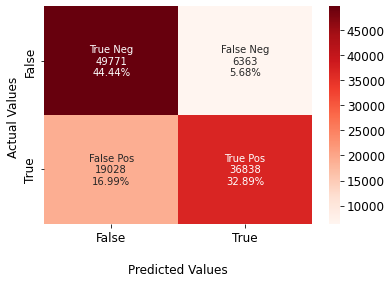

In [68]:
group_names = ['True Neg','False Neg','False Pos','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Reds')

#ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
#plt.show()
cm_match = plt.gcf()

In [69]:
cm_match.savefig("cm_match.pdf",format="pdf", bbox_inches ="tight")